# Basic Exploratory Data Analysis (EDA)


## Load Data

In [12]:
import pandas as pd

dataset_path = '../data/HPAI Detections in Wild Birds.csv'
hpai_data = pd.read_csv(dataset_path)

print(hpai_data.head(n=5)) # view the first 5 rows of the dataset


          State    County Collection Date Date Detected HPAI Strain  \
0  North Dakota      Cass       9/12/2025     9/19/2025       EA H5   
1  Pennsylvania     Bucks        9/8/2025     9/19/2025       EA H5   
2  Pennsylvania  Delaware        9/4/2025     9/19/2025       EA H5   
3    New Jersey    Warren       9/11/2025     9/19/2025       EA H5   
4    New Jersey    Warren       9/11/2025     9/19/2025       EA H5   

    Bird Species WOAH Classification      Sampling Method   Submitting Agency  
0   Canada goose           Wild bird  Morbidity/Mortality    ND Game and Fish  
1  Black vulture           Wild bird  Morbidity/Mortality  PA Game Commission  
2  Black vulture           Wild bird  Morbidity/Mortality  PA Game Commission  
3  Black vulture           Wild bird  Morbidity/Mortality              NJ DEP  
4  Black vulture           Wild bird  Morbidity/Mortality              NJ DEP  


## HPAI Cases over Time

Let's investigate the trend of HPAI cases across years and months.

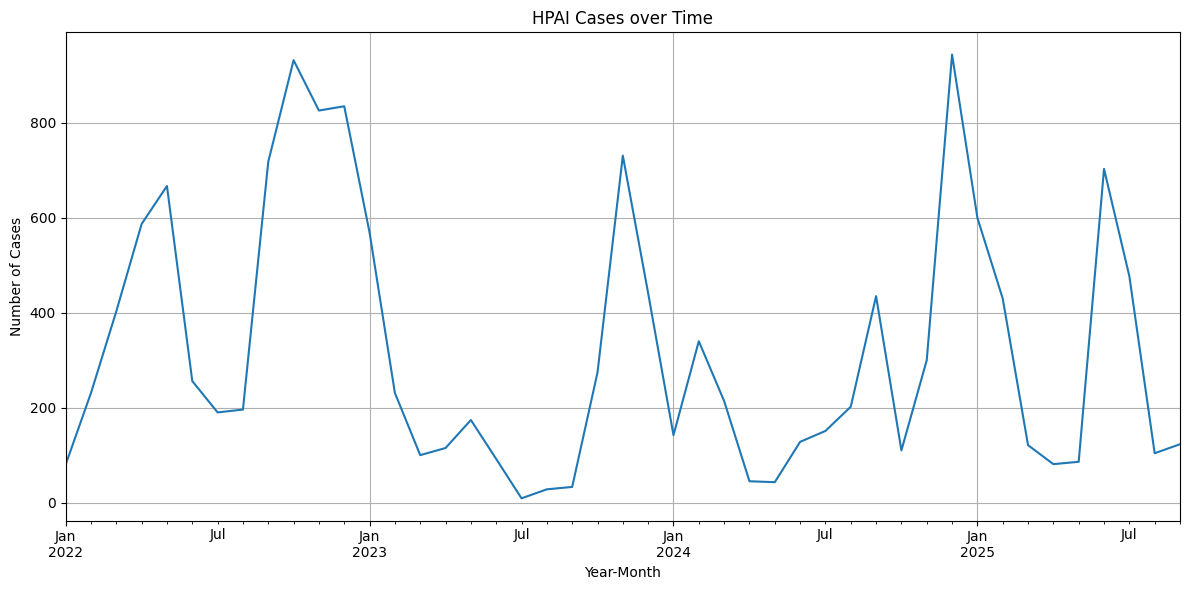

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

def parse_date(s):
    try:
        return pd.to_datetime(s, format='%m/%d/%Y', errors='coerce')
    except:
        return pd.NaT

df1 = hpai_data.copy()

df1['Date Detected'] = df1['Date Detected'].apply(parse_date)
df1 = df1.dropna(subset=['Date Detected'])
df1['year_month'] = df1['Date Detected'].dt.to_period('M')
detections_per_month = df1.groupby('year_month').size()
plt.figure(figsize=(12,6))
detections_per_month.plot()
plt.title('HPAI Cases over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Cases')
plt.grid(True)
plt.tight_layout()
plt.show()


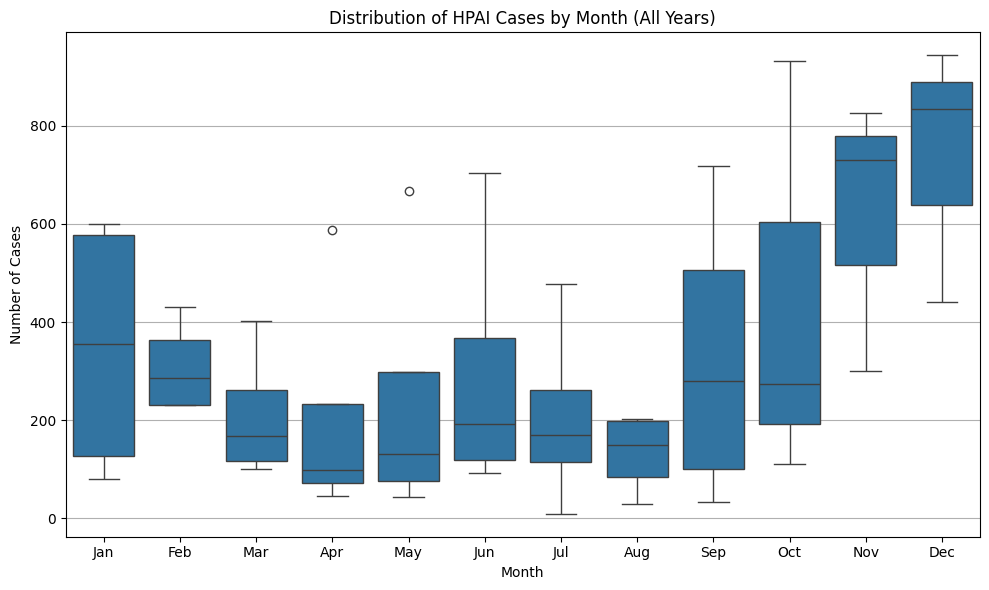

In [14]:
import seaborn as sns

# Extract month from detection date
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df1['month'] = df1['Date Detected'].dt.month
# Map month numbers to names for better readability
month_map = {i+1: name for i, name in enumerate(month_order)}
df1['month_name'] = df1['month'].map(month_map)

# Count cases per month per year
monthly_counts = df1.groupby(['year_month', 'month_name']).size().reset_index(name='cases')

plt.figure(figsize=(10,6))
sns.boxplot(x='month_name', y='cases', data=monthly_counts, order=month_order)
plt.title('Distribution of HPAI Cases by Month (All Years)')
plt.xlabel('Month')
plt.ylabel('Number of Cases')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

## Sample Collection Regularity

One possible source of bias is from how frequently submitting agencies collect samples. Some agencies may collect very few, resulting in undersampling for certain areas. On the other hand, other agencies may collect many samples, resulting in oversampling.

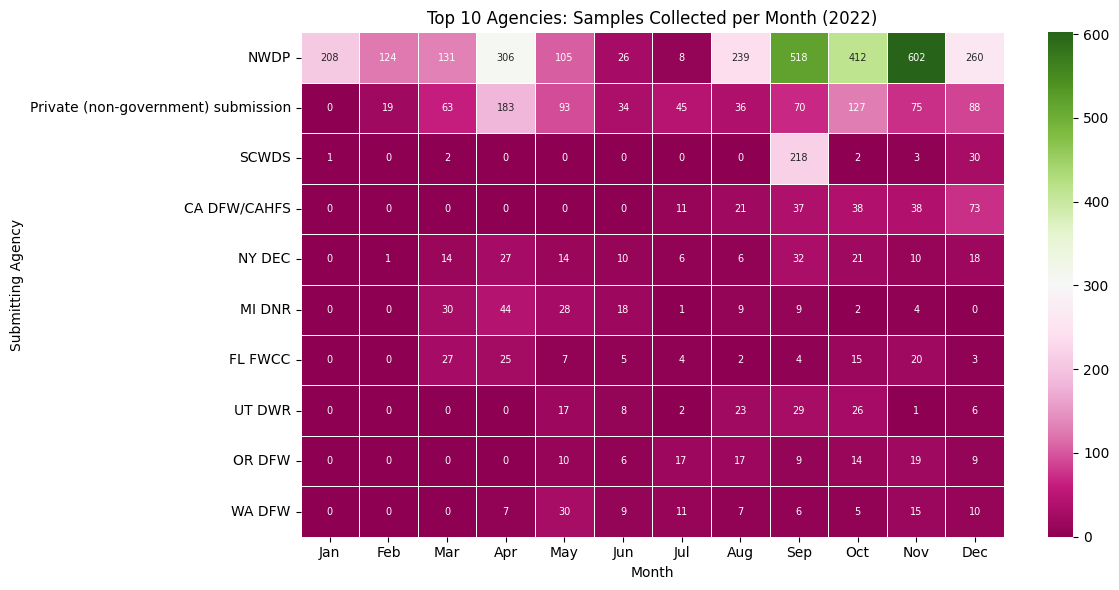

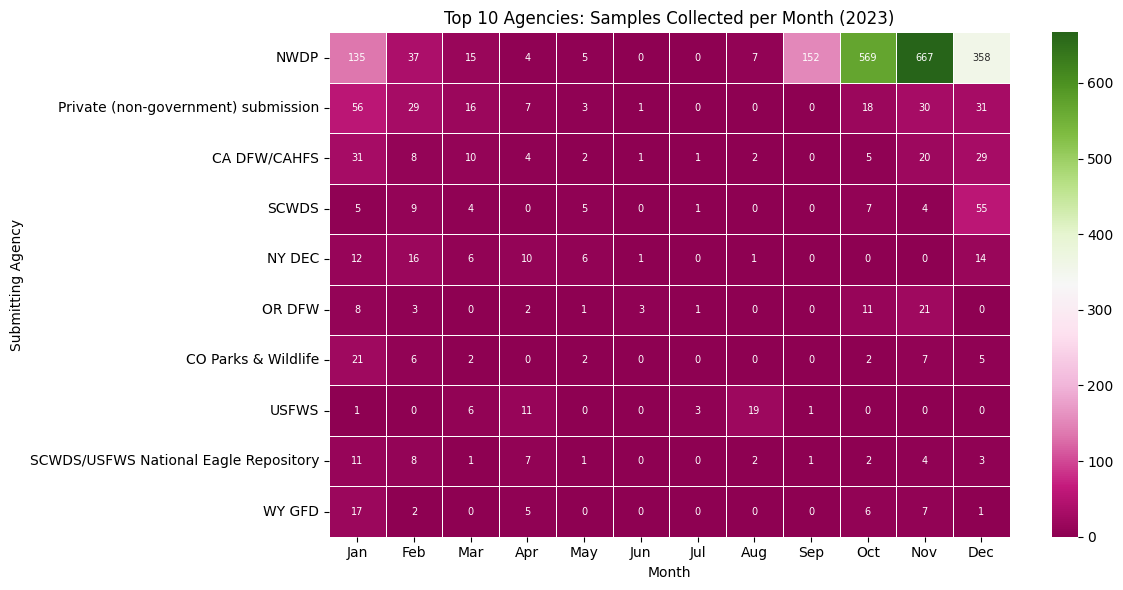

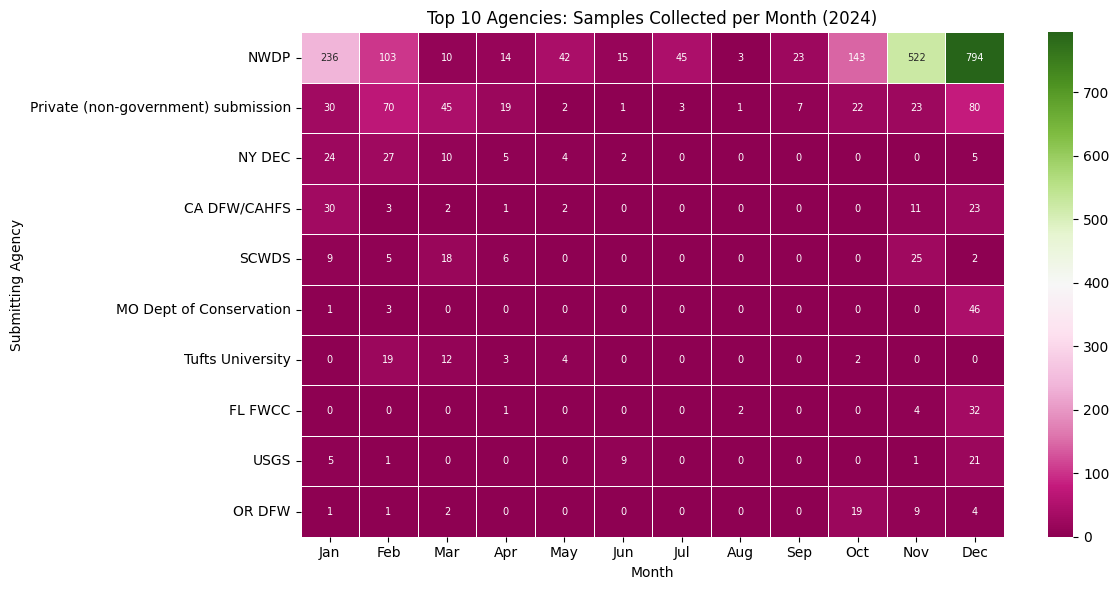

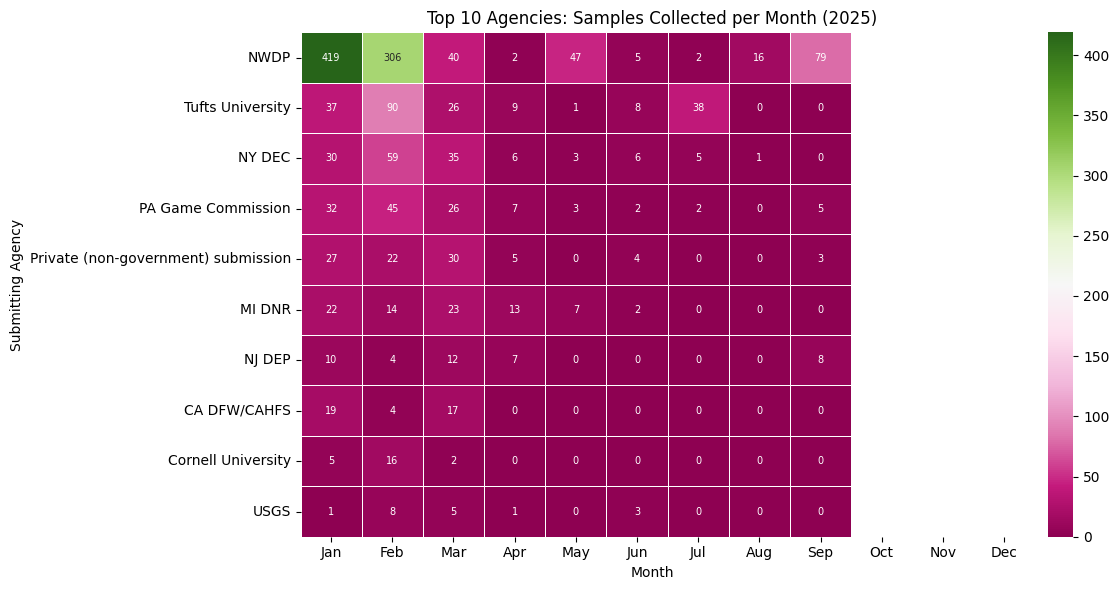

In [15]:
df2 = hpai_data.copy()
df2['Collection Date'] = df2['Collection Date'].apply(parse_date)
df2 = df2.dropna(subset=['Collection Date', 'Submitting Agency'])
df2['year'] = df2['Collection Date'].dt.year

years = sorted(df2['year'].unique())
for yr in years:
    df_year = df2[df2['year'] == yr].copy()
    df_year['month'] = df_year['Collection Date'].dt.month
    if len(df_year['month'].unique()) < 6:
        continue
    month_order = [1,2,3,4,5,6,7,8,9,10,11,12]
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    agency_month_counts = df_year.pivot_table(index='Submitting Agency', columns='month', aggfunc='size', fill_value=0)
    # Select top 10 agencies by total samples collected
    top_agencies = agency_month_counts.sum(axis=1).nlargest(10).index
    agency_month_counts = agency_month_counts.loc[top_agencies]
    plt.figure(figsize=(12,6))
    sns.heatmap(agency_month_counts, cmap='PiYG', linewidths=0.5, xticklabels=month_labels, annot=True, annot_kws={'size':7}, fmt='d')
    plt.title(f'Top 10 Agencies: Samples Collected per Month ({yr})')
    plt.xlabel('Month')
    plt.ylabel('Submitting Agency')
    plt.tight_layout()
    plt.show()

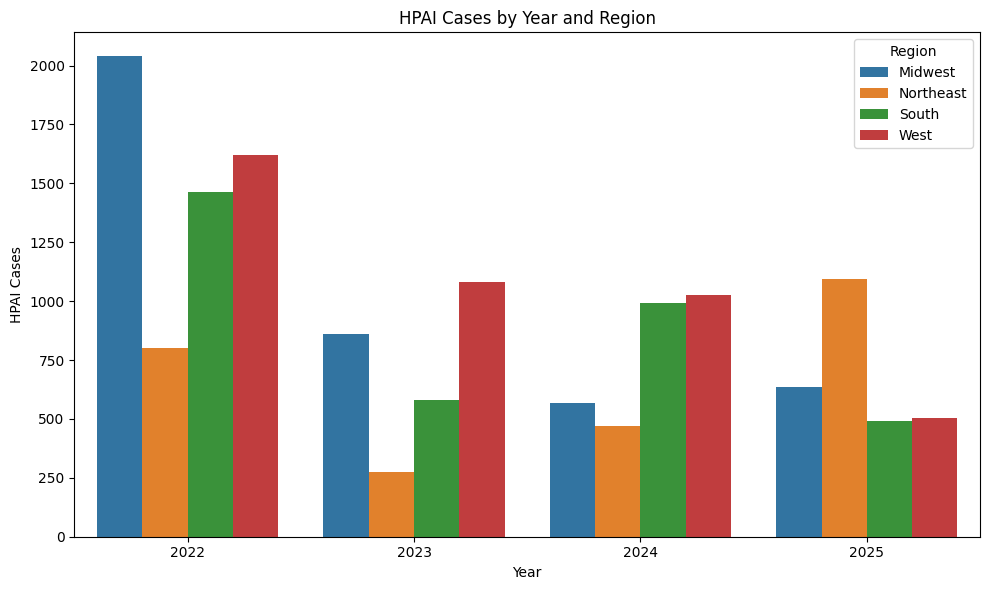

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import us

# US Census region mapping
region_map = {
    'Northeast': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA'],
    'Midwest': ['IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'],
    'South': ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'DC', 'WV', 'AL', 'KY', 'MS', 'TN', 'AR', 'LA', 'OK', 'TX'],
    'West': ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA']
}

state_to_region = {}
for region, states in region_map.items():
    for state in states:
        state_to_region[state] = region

df3 = hpai_data.copy()
df3['Date Detected'] = df3['Date Detected'].apply(parse_date)
df3 = df3.dropna(subset=['Date Detected'])
df3['Year Detected'] = df3['Date Detected'].dt.year

df3['State Abbr'] = df3['State'].apply(lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else x)
df3['Region'] = df3['State Abbr'].map(state_to_region)

region_year_counts = df3.groupby(['Year Detected', 'Region']).size().reset_index(name='Cases')

plt.figure(figsize=(10,6))
sns.barplot(data=region_year_counts, x='Year Detected', y='Cases', hue='Region')
plt.title('HPAI Cases by Year and Region')
plt.ylabel('HPAI Cases')
plt.xlabel('Year')
plt.legend(title='Region')
plt.tight_layout()
plt.show()